# Initialisation

In [1]:
### Load modules and data

import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import math
from scipy import stats
import pdb

%matplotlib inline


# Introduction

In this notebook I implement basic fine-mapping methods. Firstly I implement a basic method which calculated Bayes likelihood factors given sets of SNPs with their p-values, with the LD structure calculated from 1000 genomes.

### Single trait Bayes factor computation

### Derivation

To start, we assume that the trait $y$ is modelled as:

$$ y = X\beta + \epsilon $$

Where $X$ is an $n$x$m$ matrix of values consisting of 0,1,2 denoting whether a SNP is homozygous to the common allele, heterozygous, or homozygous to the rare allele respectively. $n$ denotes the number of samples, and $m$ the number of causitive SNPs.

We also scale $X$ such that $\frac{1}{n}\sum^{n}_{i=1} X_{ij} = 1$, and $\frac{1}{n}\sum^{n}_{i=1} X^2_{ij} = 1$ for $j = 1,2, ... m$.

We assume $\epsilon$ ~ $N(0, \frac{1}{\tau} I_n)$. We also assume $\beta$ has a prior normal distribution $N(0,\nu \frac{1}{\tau})$. $\nu$ is diagonal, $\beta$ and $\epsilon$ are independent and we assume all SNPs have the same prior variance $\sigma^2 \frac{1}{\tau}$. Therefore $\nu = \sigma^2 I_m$.

Now given this prior on $\beta$, and using $X$ and $\epsilon$, we can deduce the expectation and mean of $y$.

$$E(y \: | \: \tau, X) = E(E(y \: | \: \tau,X,\beta)) = E(X \beta) = 0$$ 

<sub>[ *since* $E(\beta) = 0$ ]</sub>

$$ Var(y \: | \: \tau, X) = E(Var(y \: | \tau, X, \beta)) + Var(E(y \: | \: \tau, X, \beta)) $$

<sub>[ *since* $Var(X \: | \: Y) = E(Var(X \: | \: Y)) + Var(E(X \: | \: Y))$ ]</sub>

$$ = E(\frac{1}{\tau}I_n) + Var(X \beta)$$

$$ = \frac{1}{\tau}( I_n + X \nu X^T)$$

Now, since y is a linear transformation of a multivariate normal random vector,

$$ y \:|\: \tau, X \sim N \left( 0,\frac{1}{\tau}( I_n + X \nu X^T)) \right) $$

The null distribution is when $\beta = 0$. In which case,

$$y \:|\: \tau, X \sim N \left( 0,\frac{1}{\tau}I_n \right) $$

Now consider a new variable $z = \sqrt{\frac{\tau}{n}} X^{T}y$:

$$ z ~ \sim N \left( 0, \frac{X^T}{n}(I_n + X \nu X^T) X \right)$$

$$ = N \left( 0, \left(\frac{X^TX}{n} + \frac{X^TX \nu X^TX}{n}\right) \right)$$

Now let $\Sigma_x = \frac{X^T X}{n}$. Since all column in $X$ are standardised, this is equivalent to the correlation matrix or, more importantantly, the linkage disequilibirum structure of the SNPs which can be derived from the 1000 genomes data.

Then we have:

$$ z \sim N(0, \Sigma_x + \Sigma_x n\nu \Sigma_x) $$

The *Bayes Factor* is the ratio of the likelihood functions under the alternative hypothesis, and under the null hypothesis. It is equivalent to the likelihood ratio.

$P_1(z \:|\: \tau, X)$, the likelihood of $z$ under our alternate hypothesis, i.e. when $\nu \neq 0$ is:

$$ P_1(z \:|\: \tau, X) = 2\pi^{-\frac{n}{2}} | \Sigma_x + \Sigma_x n\nu \Sigma_x |^{-\frac{1}{2}} \exp\left(-\frac{1}{2}z^T(\Sigma_x + \Sigma_x n\nu \Sigma_x)^{-1}z\right)$$

$P_0(z \:| \: \tau, X)$, the likelihood of $z$ under the null hypothesis when $\nu = 0$ is:

$$P_0(z \:| \: \tau, X) = 2\pi^{-\frac{n}{2}} |\Sigma_x|^{-\frac{1}{2}} \exp\left(-\frac{1}{2}z^T(\Sigma_x)^{-1}z\right)$$

Therefore we calculate the Bayes Factor as:

$$ \frac{
| \Sigma_x + n\nu \Sigma_x^2 |^{-\frac{1}{2}} \exp\left(-\frac{1}{2}z^T(\Sigma_x + \Sigma_x n\nu \Sigma_x)^{-1}z\right)
}{
|\Sigma_x|^{-\frac{1}{2}} \exp\left(-\frac{1}{2}z^T(\Sigma_x)^{-1}z\right)
}
$$

We assume that $X$ has full column rank, and that $\Sigma_x$ also has rank $m$ and is non-singular. That is to say, we assume that no two snps are in full linkage disequilibrium.

Using the Woodberry matrix identity:

$$
(\Sigma_x + \Sigma_x n\nu \Sigma_x)^{-1} = \Sigma_x^{-1} - ((n\nu)^{-1} + \Sigma_x)^{-1}
$$

Therefore the resulting Bayes Factor is:

$$
|I_m + n\nu \Sigma_x|^\frac{1}{2} \exp(\frac{1}{2}z^T((n\nu)^{-1} + \Sigma_x)^{-1}z)
$$

Crucially, this only depends on inverting matrices of size m, our candidate gene set. Therefore we compute these Bayes Factors using sets of candidate SNPs of size m, and choose the set with the highest calculated Bayes Factor.

In practice, we recieve $\beta$, $se(\beta)$, and the SNP linkage disequilibrium structure $\Sigma_x$.

Since $X$ is normalised, $\beta = X^T y$.

Also, 
$$\tau = \frac{1}{se(\beta))}$$

Therefore we generate the $z$ vector by calculating:

$$
z = \sqrt{\frac{\tau}{n}} X^{T}y = \frac{\beta}{\sqrt{n \times se(\beta)}}
$$

The Bayes Factor can then be directly calculated using $z$ and $\Sigma_x$.



In [6]:
s_tss_1=np.load('summary_stats_g1_tss60.npy')[0]
s_tss_2=np.load('summary_stats_g2_tss60.npy')[0]
LD_tss_1=np.load('LD_g1_TSS60.npy')
LD_tss_2=np.load('LD_g2_TSS60.npy')

### Generate z arrays

z1 = np.array(np.divide(s_tss_1['beta'],np.sqrt(s_tss_1['var_beta'])))
z2 = np.array(np.divide(s_tss_2['beta'],np.sqrt(s_tss_1['var_beta'])))
z1 = np.ndarray.flatten(z1)
z2 = np.ndarray.flatten(z2)

### Create selection of SNPs
def select_snps(z, subset):
    return [z[i] for i in subset]

#example
# for subset in it.combinations(range(len(z1)),3):
#     print subset, select_snps(z1, subset)    



### Select covariance submatrix

def select_cov(cov, subset):
    return cov[np.ix_(subset,subset)]

#example   
#select_cov(LD_tss_1, (0,1,5))

### Calculate Bayes Factor

def calc_BF(z, cov, v,n):
    z = np.matrix(z)
    z = z.T
    v = np.matrix(v)
    coeff = 1. / math.sqrt(np.linalg.det((np.matrix(np.eye(len(z))) + n * np.matrix(v) * np.matrix(cov))))
    exponent = 0.5* z.T * np.matrix(((n*v).I + cov)).I * z
    return np.array(math.log(coeff) + exponent)[0][0]

# example
# subset = (0,1,5,8)
# cov = select_cov(LD_tss_1, subset)
# z = select_snps(z1, subset)
# v = np.eye(len(z))/1000
# n = 1000
# calc_BF(z,cov,v,n)

def choose_variant_set(data,k,v):
    results = []
    for i in range(1,k):
        for subset in it.combinations(range(len(data[0])),i):
            z = select_snps(data[0], subset)
            cov = select_cov(data[1],subset)
            n = data[2]
            v_matrix = np.eye(len(z)) * v
            results.append((subset, calc_BF(z, cov,v_matrix,n)))
    results.sort(key=lambda x: x[1], reverse=True)
    return results[0:10]

k=5
data1 = (z1, LD_tss_1,10000)
data2 = (z2, LD_tss_2,1000)
v = 0.01
    
set1 = choose_variant_set(data1,k,v)
set2 = choose_variant_set(data2,k,v)



### Trait simulation

Given genotype data and an LD structure, simulate a trait which is linearly associated with a variant, or a set of variants. Here I generate a large mxn matrix (m=number of samples, n=number of SNPs), with 0,1,2 as elements.

Then, I can choose a set of SNPs, and from these SNPs I generate a trait with a linear model with a given parameter beta, as well as an unexplained variance parameter epsilon.

Following this, I try to recover these sets of SNPs. I generate p-values for each SNP being associated with the trait, by individually building univariate linear models for each SNPs, as I understand summary statistics are generated.

In [3]:
### Sample genotypes

def simulate_genotype(n,m,geno_dist):
    X=np.zeros([n,m])
    for i in range(m):
        X[:,i] = [np.random.choice(a=[0,1,2],p=geno_dist) for x in range(n)]
    return np.array(X)

###example
X = simulate_genotype(n=10000,m=30,geno_dist=[0.85,0.1,0.05])

In [4]:
def simulate_traits(X,eps,snp_group):
    """
    SNPs in the form e.g. {3: 0.9, 5:0.4, 8:0.5}. Dictionary values are the linear model coefficients (beta values).
    eps is the level of unexplained variance. X is the genotype information.
    """
    beta = np.array(snp_group.values()).T
    snps = snp_group.keys()
    eps_vector = np.array(np.random.normal(0,eps,X.shape[0])).T
    return np.add(np.dot(X[:,snps], beta), eps_vector)
    
###examples
y = simulate_traits(X,eps=0.5,snp_group={3: 5, 9: 3})

In [5]:
y

array([ 0.24328232,  5.28760732, -0.65985859, ...,  0.14443655,
       -0.28316576,  5.37448439])

(array([ 1894.,  5392.,   725.,   840.,   537.,   108.,   424.,    42.,
           19.,    19.]),
 array([ -2.23867636,  -0.32565703,   1.58736231,   3.50038164,
          5.41340098,   7.32642031,   9.23943965,  11.15245899,
         13.06547832,  14.97849766,  16.89151699]),
 <a list of 10 Patch objects>)

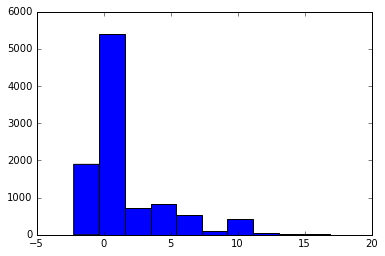

In [6]:
plt.hist(y)

In [42]:
def build_linear_models(X,y):
    return [stats.linregress(X[:,i],y) for i in range(X.shape[1])]

#example
#[x.pvalue for x in build_linear_models(X,y)]

In [9]:
stats.linregress([3,2,0], [3,2,1])

LinregressResult(slope=0.64285714285714279, intercept=0.9285714285714286, rvalue=0.98198050606196563, pvalue=0.12103771832367702, stderr=0.12371791482634874)

# Last section